In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

MAX_ITERATION = 10000

In [77]:
def logistic_data_generator(mean1, cov1, mean2, cov2, num):
    np.random.seed(0)
    X = np.random.multivariate_normal(mean1, cov1, num//2)
    np.random.seed(1)
    y = np.full(num//2, -1, dtype=int)
    X_ = np.random.multivariate_normal(mean2, cov2, num-num//2)
    y_ = np.full(num-num//2, 1, dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=50, random_state=1)
    X_train_, X_test_, y_train_, y_test_ = train_test_split(
        X_, y_, test_size=50, random_state=2)
    X_train = np.concatenate((X_train, X_train_), axis=0)
    X_test = np.concatenate((X_test, X_test_), axis=0)
    y_train = np.concatenate((y_train, y_train_))
    y_test = np.concatenate((y_test, y_test_))

    X_train, y_train = shuffle(X_train, y_train)
    X_test, y_test = shuffle(X_test, y_test)

    return X_train, y_train, X_test, y_test


def LDA_data_generator(mean1, cov1, mean2, cov2, num):
    np.random.seed(0)
    X = np.random.multivariate_normal(mean1, cov1, num//2)
    np.random.seed(1)
    y = np.full(num//2, -1, dtype=int)
    X_ = np.random.multivariate_normal(mean2, cov2, num-num//2)
    y_ = np.full(num-num//2, 1, dtype=int)
    X1 = np.concatenate((X, X_), axis=0)
    y1 = np.concatenate((y, y_))

    return shuffle(X1, y1)


def draw_logistic(X, y, w):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i in range(len(y)):
        if y[i] == 1:
            ax.scatter(X[i, 0], X[i, 1], c='r', marker='o')
        else:
            ax.scatter(X[i, 0], X[i, 1], c='b', marker='x')

    l_x = np.linspace(np.min(X), np.max(X), X.shape[0])
    l_y = -(w[0]/w[2]+w[1]/w[2]*l_x)
    ax.plot(l_x, l_y)
    xy_max = np.max(X, axis=0)
    ax.set(xlim=(-xy_max[0]-1, xy_max[0]+1), ylim=(-xy_max[1]-1, xy_max[1]+1),
           xlabel="x",
           ylabel="y",
           title="Logistic Regression")


def draw_LDA(X, y, w, st):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    for i in range(len(y)):
        if y[i] == 1:
            ax.scatter(X[i, 0], X[i, 1], c='r', marker='o')
        else:
            ax.scatter(X[i, 0], X[i, 1], c='b', marker='x')

    l_x = np.linspace(np.min(X), np.max(X), X.shape[0])
    l_y = -w[0]/w[1]*l_x+st/w[1]
    ax.plot(l_x, l_y)
    w_x = np.linspace(np.min(X), np.max(X), X.shape[0])
    w_y = w[1]/w[0]*w_x
    ax.plot(w_x, w_y)
    xy_max = np.max(X, axis=0)
    ax.set(xlim=(-xy_max[0]-1, xy_max[0]+1), ylim=(-xy_max[1]-1, xy_max[1]+1),
           xlabel="x",
           ylabel="y",
           title="LDA")


def draw_kmeans(recorder):
    assert len(
        recorder[-1]) <= 7, 'k should be less than or equal to 7, otherwise it is hard to observe the result'
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    colors = ['b', 'r', 'g', 'k', 'y', 'c', 'm']

    for index, (centroid, cluster) in enumerate(recorder[-1].items()):
        ax.scatter(np.array(cluster)[:, 0], np.array(cluster)[
                   :, 1], s=100, marker='+', c=colors[index])
        ax.scatter(centroid[0], centroid[1], s=150,
                   marker='o', c=colors[index])


def logistic_train(X_train, y_train, w_init, max_iter, lr=0.001, eps=1e-10):
    def sigmoid(s):
        return np.exp(s)/(1 + np.exp(s))

    w = w_init
    X = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
    y = y_train

    for i in range(max_iter):
        for j in range(X.shape[0]):
            diff = sigmoid(-y[j]*np.dot(w, X[j]))*(-y[j]*X[j])
            w_ = w - lr * diff

            delta = np.linalg.norm(w - w_)
            if delta < eps:
                break
            else:
                w = w_
    return w


def logistic_test(X_test, y_test, w):
    def sigmoid(s):
        return np.exp(s)/(1 + np.exp(s))

    X = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
    y = y_test

    h = np.sign(2*sigmoid(np.dot(X, w))-1)
    p = sigmoid(np.dot(X, w))
    mistake_indices = np.where(h != y)[0]
    mistake_num = len(mistake_indices)
    CE = 1/(X.shape[0]) * np.sum(np.log(1+np.exp(-y*np.dot(X, w))))
    print('CE is', CE)
    print('Accuracy is %.2f%%' %
          (100*(X.shape[0]-mistake_num)/X.shape[0]))
    for i in range(X.shape[0]):
        print('样本[%.2f, %.2f]属于-1/1类的概率分别为：[%f, %f]，因此属于%d类'
              % (X[i][1], X[i][2], 1-p[i], p[i], h[i]))

    draw_logistic(X_test, y_test, w)


def LDA(X, y):
    w1 = X[np.where(y == -1)]
    w2 = X[np.where(y == 1)]
    assert w1.shape[1] == w2.shape[1], 'Identical dimension of data should be guaranteed'

    m1 = np.average(w1, axis=0)
    m2 = np.average(w2, axis=0)
    n = w1.shape[1]

    c1 = np.zeros((n, n))
    for i in range(w1.shape[0]):
        c1 = c1 + np.dot((w1 - m1)[i].reshape(-1, 1),
                         (w1 - m1)[i].reshape(1, -1))
    c2 = np.zeros((n, n))
    for i in range(w2.shape[0]):
        c2 = c2 + np.dot((w2 - m2)[i].reshape(-1, 1),
                         (w2 - m2)[i].reshape(1, -1))
    c = c1 + c2

    w = np.linalg.pinv(c).dot((m1 - m2))
    m1_ = np.dot(w, m1)
    m2_ = np.dot(w, m2)
    st = 1/2 * (m1_ + m2_)

    print("最佳投影向量：", w)
    print("分类阈值：", st)

    return w, st


def kmeans(X, k):
    def random_centroids(X, k):
        random_index = np.random.choice(X.shape[0], k, replace=False)
        return X[random_index]

    def update_centroids(epoch):
        new_centroids = []
        for i in epoch.values():
            new_centroids.append(np.average(np.array(i), axis=0))
        return np.array(new_centroids)

    assert k <= X.shape[0], 'k should be less than or equal to the number of examples'

    centroids = random_centroids(X, k)
    recorder = []
    converged = False

    while not converged:
        epoch = {tuple(i): [] for i in centroids}
        for i in range(len(X)):
            min_dist = np.inf
            min_centroid = (np.inf, np.inf)
            for j in epoch.keys():
                dist = np.linalg.norm(X[i]-j)
                if min_dist > dist:
                    min_dist = dist
                    min_centroid = j
            epoch[min_centroid].append(X[i])
        recorder.append(epoch)
        new_centroids = update_centroids(epoch)
        if (new_centroids == centroids).all():
            converged = True
        else:
            centroids = new_centroids

    return recorder

# Logistic Regression

CE is 6.042771553259536e-05
Accuracy is 100.00%
样本[3.56, -0.50]属于-1/1类的概率分别为：[0.000104, 0.999896]，因此属于1类
样本[4.73, 0.53]属于-1/1类的概率分别为：[0.000006, 0.999994]，因此属于1类
样本[-4.14, -0.74]属于-1/1类的概率分别为：[0.999963, 0.000037]，因此属于-1类
样本[4.86, -0.12]属于-1/1类的概率分别为：[0.000004, 0.999996]，因此属于1类
样本[-5.03, 0.43]属于-1/1类的概率分别为：[0.999997, 0.000003]，因此属于-1类
样本[5.12, 1.13]属于-1/1类的概率分别为：[0.000002, 0.999998]，因此属于1类
样本[-4.36, -1.62]属于-1/1类的概率分别为：[0.999977, 0.000023]，因此属于-1类
样本[-4.42, 0.35]属于-1/1类的概率分别为：[0.999984, 0.000016]，因此属于-1类
样本[5.87, -2.30]属于-1/1类的概率分别为：[0.000000, 1.000000]，因此属于1类
样本[-5.06, -0.11]属于-1/1类的概率分别为：[0.999997, 0.000003]，因此属于-1类
样本[-5.65, -0.52]属于-1/1类的概率分别为：[0.999999, 0.000001]，因此属于-1类
样本[4.29, 1.19]属于-1/1类的概率分别为：[0.000019, 0.999981]，因此属于1类
样本[4.88, -0.18]属于-1/1类的概率分别为：[0.000004, 0.999996]，因此属于1类
样本[5.28, -0.73]属于-1/1类的概率分别为：[0.000001, 0.999999]，因此属于1类
样本[-3.51, -2.07]属于-1/1类的概率分别为：[0.999797, 0.000203]，因此属于-1类
样本[-5.31, 0.06]属于-1/1类的概率分别为：[0.999998, 0.000002]，因此属于-1类
样本[-3.77, 1.20]属于-1/1类的概率分别为：[

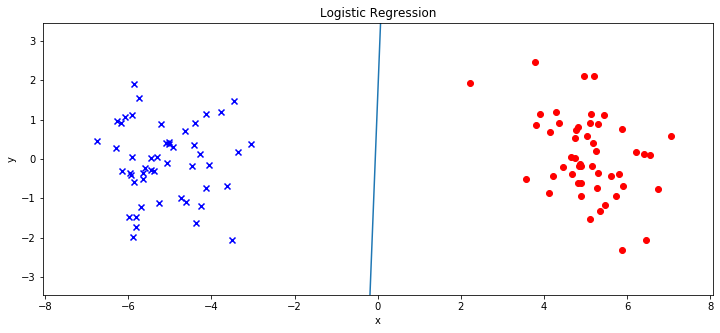

In [78]:
X1_train, y1_train, X1_test, y1_test = logistic_data_generator([-5, 0], 
                                                               np.identity(2), 
                                                               [5, 0], 
                                                               np.identity(2), 400)
np.random.seed()
w_init = np.random.randn(3)
w1 = logistic_train(X1_train, y1_train, w_init, MAX_ITERATION)
logistic_test(X1_test, y1_test, w)

# Fisher Discriminant Analysis

最佳投影向量： [-0.02629717 -0.00222113]
分类阈值： -8.890360166412259e-05


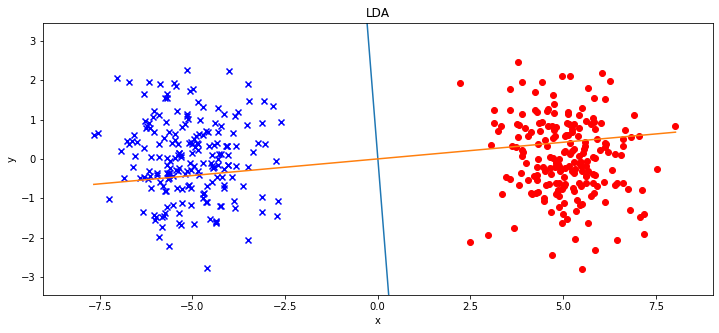

In [101]:
X2, y2 = LDA_data_generator([-5, 0], np.identity(2), [5, 0], np.identity(2), 400)
w2, st = LDA(X2, y2)
draw_LDA(X2, y2, w2, st)

# K-Means

In [ ]:
X3 = np.array([[0.697, 0.460],
               [0.774, 0.376],
               [0.634, 0.264],
               [0.608, 0.318],
               [0.556, 0.215],
               [0.403, 0.237],
               [0.481, 0.149],
               [0.437, 0.211],
               [0.666, 0.091],
               [0.243, 0.267],
               [0.245, 0.057],
               [0.343, 0.099],
               [0.639, 0.161],
               [0.657, 0.198],
               [0.360, 0.370],
               [0.593, 0.042],
               [0.719, 0.103],
               [0.359, 0.188],
               [0.339, 0.241],
               [0.282, 0.257],
               [0.748, 0.232],
               [0.714, 0.346],
               [0.483, 0.312],
               [0.478, 0.437],
               [0.525, 0.369],
               [0.751, 0.489],
               [0.532, 0.472],
               [0.473, 0.376],
               [0.725, 0.445],
               [0.446, 0.459]])

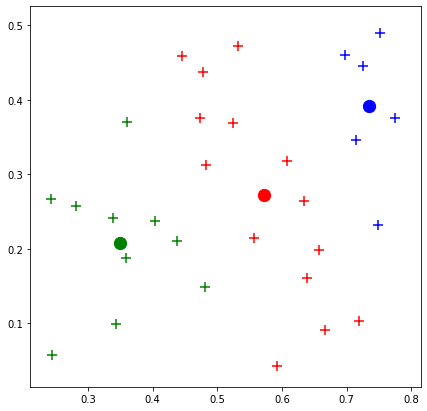

In [57]:
recorder = kmeans(X3, 3)
draw_kmeans(recorder)

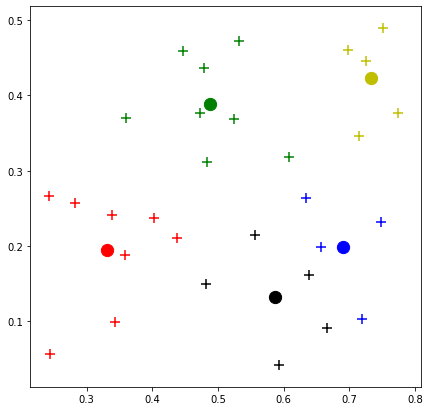

In [55]:
recorder = kmeans(X3, 5)
draw_kmeans(recorder)